In [1]:
# Packages

import selfies as sf
import pathlib as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pyarrow as pa
import joblib
import time
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
# Loading df_mofs_v3 (standardized) via parquet to retain types

df_mofs_v3 = pd.read_parquet(r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_processed data\df_mofs_v3.parquet")

In [4]:
df_mofs_v3.columns

Index(['MOFid', 'metal', 'linker', 'logKH_CO2', 'pure_uptake_CO2_298.00_15000',
       'pure_uptake_methane_298.00_6500000', 'LCD', 'PLD', 'LFPD', 'cm3_g',
       'ASA_m2_cm3', 'ASA_m2_g', 'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF',
       'AV_cm3_g', 'NAV_cm3_g', 'All_Metals', 'Has_OMS', 'Open_Metal_Sites',
       'metal_ids', 'metal_oms_flags', 'linker_ids'],
      dtype='object')

In [5]:
# Help functions

def stratified_split(df, target_col='logKH_CO2', test_size=0.1, val_size=0.1, random_state=42):
    
    # Default target column is set to be 'logKH_CO2' because it seems to be the most important
    
    df = df.copy()
    df['group'] = pd.qcut(df[target_col], q=5, labels=False, duplicates='drop')
    
    # Splitting data into train_val and test sets
    train_val, test = train_test_split(
        df, 
        test_size=test_size,
        stratify=df['group'],
        random_state=random_state # Same random seed
    )
    
    # Splitting train_val into train and validation sets
    val_size_adjusted = val_size / (1 - test_size) # To make sure that the val_size is retained
    train, val = train_test_split(
        train_val,
        test_size=val_size_adjusted,
        stratify=train_val['group'],
        random_state=random_state # Same random seed
    )
    
    # Dropping group column
    train = train.drop(columns=['group'])
    val = val.drop(columns=['group'])
    test = test.drop(columns=['group'])
    
    # Results
    print(f"Train: {len(train)} ({len(train)/len(df)*100:.1f}%)")
    print(f"Val:   {len(val)} ({len(val)/len(df)*100:.1f}%)")
    print(f"Test:  {len(test)} ({len(test)/len(df)*100:.1f}%)")
    print(f"\n{target_col} Average:")
    print(f"Train: {train[target_col].mean():.3f}")
    print(f"Val:   {val[target_col].mean():.3f}")
    print(f"Test:  {test[target_col].mean():.3f}")
    
    return train, val, test

def plot_split_distributions(train_df, val_df, test_df, columns):
    
    # To show the distribution of Train / Val / Test datasets

    fig, axes = plt.subplots(1, len(columns), figsize=(5*len(columns), 4))
    
    if len(columns) == 1:
        axes = [axes]
    
    for i, col in enumerate(columns):
        axes[i].hist(train_df[col], alpha=0.5, label='Train', bins=30, density=True) # Density to compare datasets with normalized distributions
        axes[i].hist(val_df[col], alpha=0.5, label='Val', bins=30, density=True)
        axes[i].hist(test_df[col], alpha=0.5, label='Test', bins=30, density=True)
        axes[i].set_title(col)
        axes[i].legend()
        axes[i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()




In [7]:

# Train / Val / Test dataset split
train_df, val_df, test_df = stratified_split(
    df_mofs_v3, 
    target_col='logKH_CO2',  # The most important target value (As a split reference)
    test_size=0.1,           # 10 % test split
    val_size=0.1             # 10 % validation split
)

# Saving Train / Val / Test dataset in parquet forms.

train_df.to_parquet(r'C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_processed data\train_df.parquet', index=False)
val_df.to_parquet(r'C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_processed data\val_df.parquet', index=False)
test_df.to_parquet(r'C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_processed data\test_df.parquet', index=False)

Train: 2665 (80.0%)
Val:   334 (10.0%)
Test:  334 (10.0%)

logKH_CO2 Average:
Train: -0.001
Val:   -0.006
Test:  0.016


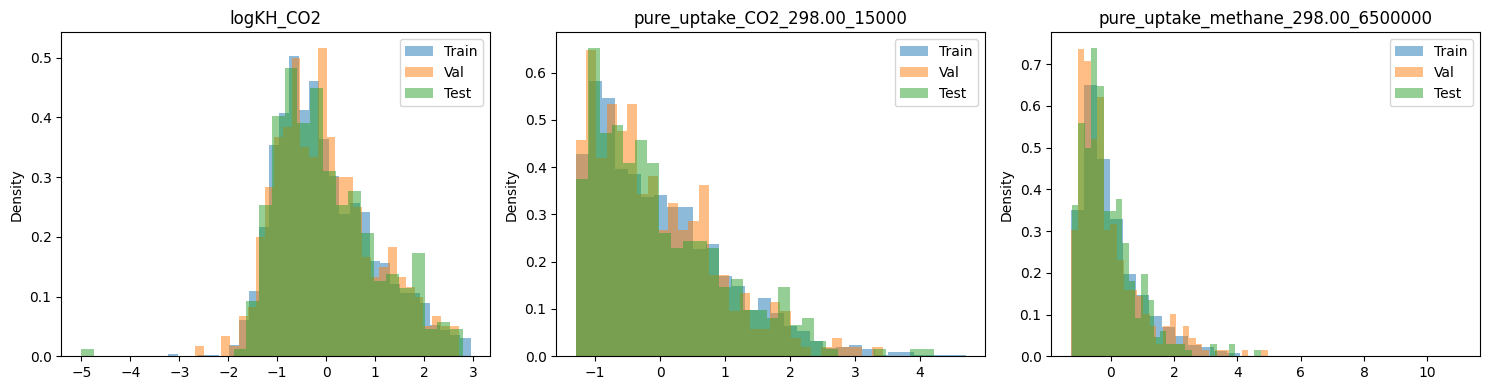

In [8]:
# Distribution of Train / Val / Test datasets; looking for similarity

plot_split_distributions(
    train_df, 
    val_df, 
    test_df, 
    columns=['logKH_CO2', 'pure_uptake_CO2_298.00_15000',
       'pure_uptake_methane_298.00_6500000']
)

In [9]:
class MOFDataset(Dataset):
    def __init__(self, df, geometry_cols, target_cols):
        self.df = df # getting the dataset
        self.geometry_cols = geometry_cols # getting the geometry columns
        self.target_cols = target_cols # getting the target columns

    def __len__(self): # returns the length of the dataset
        return len(self.df) 

    def __getitem__(self, idx): # returns the item at the given index
            row = self.df.iloc[idx]
            
            geometry = torch.tensor(
                row[self.geometry_cols].values.astype(np.float32), 
                dtype=torch.float32 # Float 32
            )
            
            metal_ids = torch.tensor(
                row['metal_ids'], 
                dtype=torch.long # Long integer
            )
            
            metal_oms = torch.tensor(
                row['metal_oms_flags'], 
                dtype=torch.long # Long integer
            )
            
            linker_ids = torch.tensor(
                row['linker_ids'], 
                dtype=torch.long # Long integer
            )
            
            targets = torch.tensor(
                row[self.target_cols].values.astype(np.float32), 
                dtype=torch.float32 # Float 32
            )
            
            return {
                'geometry': geometry, # geometry features
                'metal_ids': metal_ids, # metal ids
                'metal_oms': metal_oms, # metal oms
                'linker_ids': linker_ids, # linker ids
                'targets': targets # targets
            }

In [10]:
geometry_cols = ['LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g', 
                 'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF', 'AV_cm3_g', 'NAV_cm3_g']

target_cols = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 
               'pure_uptake_methane_298.00_6500000']

# Using split train / val / test datasets from the previous step, we can create the dataset for the model (torch and datatype)

train_dataset = MOFDataset(train_df, geometry_cols, target_cols)
val_dataset = MOFDataset(val_df, geometry_cols, target_cols)
test_dataset = MOFDataset(test_df, geometry_cols, target_cols)

# Creating the dataloader for train / val / test datasets

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 84
Val batches: 11
Test batches: 11


In [11]:
print(f"Train dataset type: {type(train_dataset)}")
train_dataset[0]

Train dataset type: <class '__main__.MOFDataset'>


{'geometry': tensor([ 1.2192,  0.9166,  1.2785, -1.4690,  1.5964,  2.4373, -0.4723, -0.4310,
          2.0114,  1.6320, -0.0252]),
 'metal_ids': tensor([13,  0,  0,  0,  0]),
 'metal_oms': tensor([1, 0, 0, 0, 0]),
 'linker_ids': tensor([47, 24, 37, 72, 47, 24, 47, 24, 37, 37, 47, 24, 67, 20, 47, 20, 47, 28,
         59, 47, 24, 38, 67,  1, 47, 24, 47, 20, 27, 24, 47, 20, 68, 24, 67, 20,
         47, 20, 47, 28, 59, 47, 20, 47, 28, 59, 47, 24, 68, 67, 61, 47, 24, 47,
         24, 37, 37, 47, 24, 67, 20, 47, 20, 47, 28, 59,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0

In [12]:
# Loading the vocabularies of metals and linkers

metal_vocab = joblib.load('metal_vocabulary.pkl')
print(f"Metal vocab type: {type(metal_vocab)}")
print(f"Metal vocab: {metal_vocab}")
print(f"Length of metal vocab: {len(metal_vocab)}, Unique metals: {len(metal_vocab)-1}, padding index: {metal_vocab['[nop]']}")

linker_vocab = joblib.load('linker_vocabulary.pkl')
print(f"\nLinker data type: {type(linker_vocab)}")
print(f"Metal vocab: {linker_vocab}")
print(f"Length of linker vocab: {len(linker_vocab)}, Unique linker components: {len(linker_vocab)-1}, padding index: {linker_vocab['[nop]']}")

Metal vocab type: <class 'dict'>
Metal vocab: {'[nop]': 0, 'Ag': 1, 'Al': 2, 'Au': 3, 'Ba': 4, 'Be': 5, 'Bi': 6, 'Ca': 7, 'Cd': 8, 'Ce': 9, 'Co': 10, 'Cr': 11, 'Cs': 12, 'Cu': 13, 'Dy': 14, 'Er': 15, 'Eu': 16, 'Fe': 17, 'Ga': 18, 'Gd': 19, 'Hf': 20, 'Ho': 21, 'In': 22, 'Ir': 23, 'K': 24, 'La': 25, 'Li': 26, 'Lu': 27, 'Mg': 28, 'Mn': 29, 'Mo': 30, 'Na': 31, 'Nb': 32, 'Nd': 33, 'Ni': 34, 'Pb': 35, 'Pd': 36, 'Pr': 37, 'Pt': 38, 'Rb': 39, 'Re': 40, 'Rh': 41, 'Ru': 42, 'Sm': 43, 'Sn': 44, 'Sr': 45, 'Tb': 46, 'Th': 47, 'Tm': 48, 'U': 49, 'V': 50, 'W': 51, 'Y': 52, 'Yb': 53, 'Zn': 54}
Length of metal vocab: 55, Unique metals: 54, padding index: 0

Linker data type: <class 'dict'>
Metal vocab: {'[nop]': 0, '[#Branch1]': 1, '[#Branch2]': 2, '[#CH0]': 3, '[#C]': 4, '[#N]': 5, '[/-Ring1]': 6, '[/-Ring2]': 7, '[/Br]': 8, '[/C@@H1]': 9, '[/C@@]': 10, '[/C@H1]': 11, '[/C@]': 12, '[/CH0]': 13, '[/CH1]': 14, '[/C]': 15, '[/NH0]': 16, '[/NH1]': 17, '[/N]': 18, '[/S]': 19, '[=Branch1]': 20, '[=Branch2]'

In [13]:
# Setting the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [ ]:
class SimpleBaselineModel(nn.Module):
    
    """
    Simple baseline Model:
    1. Encode each modality (geometry, metal, linker) separately
    2. Concatenate the encoded modalities
    3. Embed the concatenated vector using Predictor MLP
    4. Predict the 3 target properties (logKH_CO2, pure_uptake_CO2_298.00_15000, pure_uptake_methane_298.00_6500000)
    
    
    Architecture:
    Geometry → MLP → embedding
    Metal → Embedding → MLP → embedding
    Linker → Embedding → MLP → embedding
    → Concat → MLP → 3 outputs
    """
    
    def __init__(self, 
                 n_geometry=11, # 11 unique geometry features are identified in the dataset
                 metal_vocab_size=55, # The metal vocab has length of 55 with padding
                 linker_vocab_size=86, # The linker vocab has length of 86 with padding
                 max_metals=5, # The maximum number of metals that a MOF has in the dataset is 5
                 max_linker_len=198, # The maxmum number of linker components that a MOF has in the dataset is 198
                 hidden_dim=128): 
        super().__init__()
        
        # 1. Geometry encoder (MLP)
        self.geometry_encoder = nn.Sequential(
            nn.Linear(n_geometry, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # 2. Metal encoder
        self.metal_id_embedding = nn.Embedding(metal_vocab_size, hidden_dim, padding_idx=0) # building metal_ids lookup table for each metal id (Trainable)
        self.metal_oms_embedding = nn.Embedding(2, hidden_dim) # 2, because 0 for closed, 1 for open metal site

        self.metal_encoder = nn.Sequential(
            nn.Linear(max_metals * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # 3. Linker encoder
        self.linker_embedding = nn.Embedding(linker_vocab_size, hidden_dim, padding_idx=0) # building linker_ids lookup table for each metal id (Trainable)
        self.linker_encoder = nn.Sequential(
            nn.Linear(max_linker_len * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # 4. Fusion & prediction
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),# Dropout rate set to 0.3 to somehow ensure each neuron learns something unique (somehow has some meanings)
            nn.Linear(hidden_dim, 3)  # 3 target properties
        )
    
    def forward(self, geometry, metal_ids, metal_oms, linker_ids):
        # Encode geometry
        geo_emb = self.geometry_encoder(geometry)  # (batch, hidden_dim)
        
        # Encode metal_ids + metal_OMS
        metal_emb = self.metal_id_embedding(metal_ids) + self.metal_oms_embedding(metal_oms)  # (batch, max_metals, hidden_dim)

        valid_mask = (metal_ids != 0).unsqueeze(-1) # if PAD, putting it as False (Mask for PAD)
        metal_emb = metal_emb * valid_mask

        metal_emb = metal_emb.view(metal_emb.size(0), -1)  # Flatten
        metal_emb = self.metal_encoder(metal_emb)  # (batch, hidden_dim)
        
        # Encode linker
        linker_emb = self.linker_embedding(linker_ids)  # (batch, max_linker_len, hidden_dim)
        linker_emb = linker_emb.view(linker_emb.size(0), -1)  # Flatten
        linker_emb = self.linker_encoder(linker_emb)  # (batch, hidden_dim)
        
        # Concatenate all
        combined = torch.cat([geo_emb, metal_emb, linker_emb], dim=1)  # (batch, hidden_dim*3)
        
        # Predict
        output = self.predictor(combined)  # (batch, 3)
        return output

In [36]:
# Training for regression
def train_model_regression(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    lr=1e-4,
    device=None,
    save_checkpoints=True,
):

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    model = model.to(device)

    model_name = model.__class__.__name__

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize history objects
    train_loss_hist = np.zeros(num_epochs)
    val_loss_hist   = np.zeros(num_epochs)
    val_r2_hist     = np.zeros(num_epochs)

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        n_train_batches = 0

        for batch in train_loader:
            geometry   = batch["geometry"].to(device)
            metal_ids  = batch["metal_ids"].to(device)
            metal_oms = batch["metal_oms"].to(device)
            linker_ids = batch["linker_ids"].to(device)
            targets    = batch["targets"].to(device)

            optimizer.zero_grad()
            outputs = model(geometry, metal_ids, metal_oms, linker_ids)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            n_train_batches += 1

        avg_train_loss = running_train_loss / n_train_batches
        train_loss_hist[epoch] = avg_train_loss

        # Validation
        model.eval()
        running_val_loss = 0.0
        n_val_batches = 0
        all_val_preds = []
        all_val_targets = []

        with torch.no_grad():
            for batch in val_loader:
                geometry   = batch["geometry"].to(device)
                metal_ids  = batch["metal_ids"].to(device)
                metal_oms = batch["metal_oms"].to(device)
                linker_ids = batch["linker_ids"].to(device)
                targets    = batch["targets"].to(device)

                outputs = model(geometry, metal_ids, metal_oms, linker_ids)

                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
                n_val_batches += 1

                all_val_preds.append(outputs.cpu().numpy())
                all_val_targets.append(targets.cpu().numpy())

        avg_val_loss = running_val_loss / n_val_batches
        val_loss_hist[epoch] = avg_val_loss

        all_val_preds = np.concatenate(all_val_preds, axis=0)
        all_val_targets = np.concatenate(all_val_targets, axis=0)

        val_r2 = r2_score(all_val_targets, all_val_preds)
        val_r2_hist[epoch] = val_r2

        # Print out results per epoch
        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"Val R²: {val_r2:.4f}"
        )

        # Save model state per epoch
        if save_checkpoints:
            ckpt_path = f"{model_name}_{lr}lr_epoch{epoch+1}.pt"
            torch.save(model.state_dict(), str(ckpt_path))

    elapsed = time.time() - start_time
    print(f"Finished Training in {elapsed:.2f} seconds")

    # save history in csv files
    np.savetxt(f"{model_name}_{lr}lr_total{num_epochs}epoch_train_loss.csv", train_loss_hist)
    np.savetxt(f"{model_name}_{lr}lr_total{num_epochs}epoch_val_loss.csv",   val_loss_hist)
    np.savetxt(f"{model_name}_{lr}lr_total{num_epochs}epoch_val_r2.csv",     val_r2_hist)

    history = {
        "train_loss": train_loss_hist,
        "val_loss":   val_loss_hist,
        "val_r2":     val_r2_hist,
    }
    return history


In [37]:
def evaluate_model(
    model,
    test_loader,
    target_names = ['logKH_CO2', 
                    'pure_uptake_CO2_298.00_15000', 
                    'pure_uptake_methane_298.00_6500000'],
    device=None,
):

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    model = model.to(device)
    model.eval()

    test_preds = []
    test_targets = []

    with torch.no_grad():
        for test_batch in test_loader:
            geometry   = test_batch['geometry'].to(device)
            metal_ids  = test_batch['metal_ids'].to(device)
            metal_oms  = test_batch['metal_oms'].to(device)
            linker_ids = test_batch['linker_ids'].to(device)
            targets    = test_batch['targets'].to(device)

            outputs = model(geometry, metal_ids, metal_oms, linker_ids)

            test_preds.append(outputs.cpu().numpy())
            test_targets.append(targets.cpu().numpy())

    test_preds = np.concatenate(test_preds, axis=0)
    test_targets = np.concatenate(test_targets, axis=0)

    for i, name in enumerate(target_names):
        y_true = test_targets[:, i]
        y_pred = test_preds[:, i]

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2   = r2_score(y_true, y_pred)

        print(f"\n{name}:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²:   {r2:.4f}")

    return test_targets, test_preds

def plot_training_curves(path_train_loss, path_val_loss, path_val_r2):

    train_loss = np.loadtxt(path_train_loss)
    val_loss   = np.loadtxt(path_val_loss)
    val_r2     = np.loadtxt(path_val_r2)

    epochs = np.arange(1, len(train_loss) + 1)

    # Loss
    plt.figure(figsize=(6,4))
    plt.title("Train vs Validation Loss")
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    # R²
    plt.figure(figsize=(6,4))
    plt.title("Validation R²")
    plt.plot(epochs, val_r2, label="Val R²")
    plt.xlabel("Epoch")
    plt.ylabel("R²")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


def plot_regression_scatter(all_targets, all_preds, target_names=..., suptitle=None):
    n_targets = all_targets.shape[1]
    fig, axes = plt.subplots(1, n_targets, figsize=(5 * n_targets, 4))

    if n_targets == 1:
        axes = [axes]

    for i, name in enumerate(target_names):
        y_true = all_targets[:, i]
        y_pred = all_preds[:, i]

        r2   = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        ax = axes[i]
        ax.scatter(y_true, y_pred, alpha=0.5)

        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        ax.set_title(f"{name}\nR²={r2:.3f}, RMSE={rmse:.3f}")
        ax.grid(alpha=0.3)

    if suptitle is not None:
        fig.suptitle(suptitle)

    plt.tight_layout()
    plt.show()


In [38]:
BaselineModel = SimpleBaselineModel(
    n_geometry=11,
    metal_vocab_size=55,
    linker_vocab_size=86,
    max_metals=5,
    max_linker_len=198,
    hidden_dim=128
)

print(BaselineModel)

SimpleBaselineModel(
  (geometry_encoder): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (metal_id_embedding): Embedding(55, 128, padding_idx=0)
  (metal_oms_embedding): Embedding(2, 128)
  (metal_encoder): Sequential(
    (0): Linear(in_features=640, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (linker_embedding): Embedding(86, 128, padding_idx=0)
  (linker_encoder): Sequential(
    (0): Linear(in_features=25344, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (predictor): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)


In [39]:
train_history = train_model_regression(
    model=BaselineModel,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    lr=1e-4,
    device='cuda',
    save_checkpoints=True
)

Epoch 1/50 | Train Loss: 0.7395 | Val Loss: 0.5355 | Val R²: 0.4391
Epoch 2/50 | Train Loss: 0.4689 | Val Loss: 0.4258 | Val R²: 0.5479
Epoch 3/50 | Train Loss: 0.3706 | Val Loss: 0.3594 | Val R²: 0.6156
Epoch 4/50 | Train Loss: 0.3140 | Val Loss: 0.3669 | Val R²: 0.6090
Epoch 5/50 | Train Loss: 0.2796 | Val Loss: 0.3201 | Val R²: 0.6567
Epoch 6/50 | Train Loss: 0.2400 | Val Loss: 0.3097 | Val R²: 0.6669
Epoch 7/50 | Train Loss: 0.2122 | Val Loss: 0.3094 | Val R²: 0.6670
Epoch 8/50 | Train Loss: 0.1861 | Val Loss: 0.3022 | Val R²: 0.6746
Epoch 9/50 | Train Loss: 0.1704 | Val Loss: 0.3034 | Val R²: 0.6739
Epoch 10/50 | Train Loss: 0.1557 | Val Loss: 0.2941 | Val R²: 0.6852
Epoch 11/50 | Train Loss: 0.1383 | Val Loss: 0.3054 | Val R²: 0.6730
Epoch 12/50 | Train Loss: 0.1304 | Val Loss: 0.3199 | Val R²: 0.6579
Epoch 13/50 | Train Loss: 0.1235 | Val Loss: 0.3143 | Val R²: 0.6645
Epoch 14/50 | Train Loss: 0.1162 | Val Loss: 0.3308 | Val R²: 0.6511
Epoch 15/50 | Train Loss: 0.1123 | Val Loss

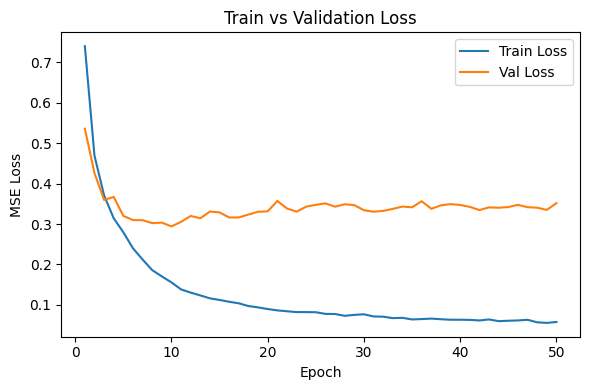

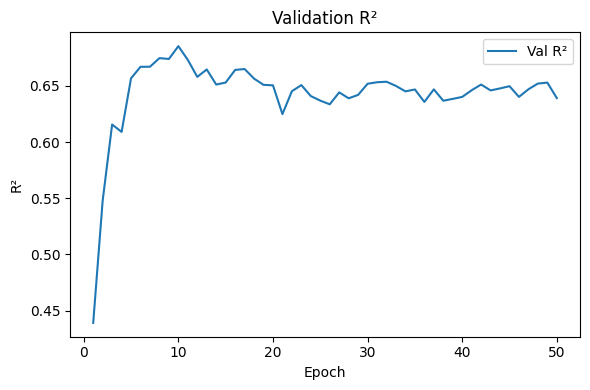

In [93]:
path_train_loss_baseline = r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\runs\SimpleBaselineModel_0.0001lr_total50epoch\SimpleBaselineModel_0.0001lr_total50epoch_train_loss.csv"
path_val_loss_baseline = r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\runs\SimpleBaselineModel_0.0001lr_total50epoch\SimpleBaselineModel_0.0001lr_total50epoch_val_loss.csv"
path_val_r2_baseline = r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\runs\SimpleBaselineModel_0.0001lr_total50epoch\SimpleBaselineModel_0.0001lr_total50epoch_val_r2.csv"

plot_training_curves(path_train_loss_baseline, path_val_loss_baseline, path_val_r2_baseline)

In [98]:
# Use early stopped model for testing (epoch at 8 gave the lowest validation loss)

test_model_baseline = SimpleBaselineModel()

test_model_baseline.load_state_dict(torch.load(r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\runs\SimpleBaselineModel_0.0001lr_total50epoch\SimpleBaselineModel_0.0001lr_epoch8.pt"))

test_result = evaluate_model(test_model_baseline, test_loader, target_names = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 
               'pure_uptake_methane_298.00_6500000'], device='cuda')


logKH_CO2:
  RMSE: 0.7252
  R²:   0.5116

pure_uptake_CO2_298.00_15000:
  RMSE: 0.7724
  R²:   0.4130

pure_uptake_methane_298.00_6500000:
  RMSE: 0.2012
  R²:   0.9484


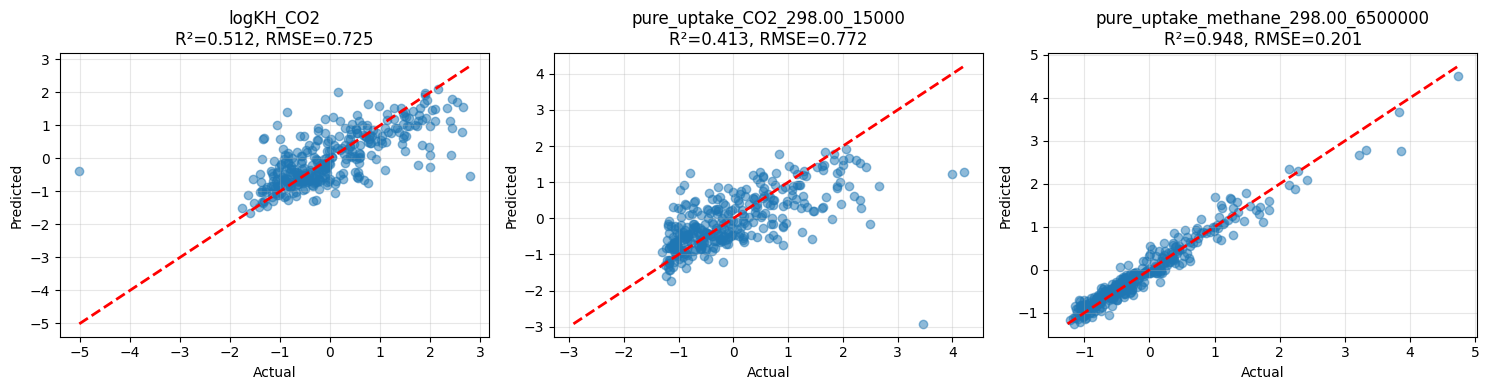

In [99]:
plot_regression_scatter(*test_result, target_names = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 
               'pure_uptake_methane_298.00_6500000'])

In [ ]:
import torch
import torch.nn as nn

class MetalLinkerSelfAttnModel(nn.Module):
    """
    Metal + linker self-attention model:

    1. Geometry → MLP → geometry embedding
    2. Metal + OMS + Linker → sequence -> self-attention Transformer Encoder
       - Form of the sequence : [CLS] Metals embedding [SEP] Linkers embedding (This includes the padding as well)
       - Using specialized [CLS] token as to update hidden state
    3. [geometry_emb, cls_emb] concat → predictor MLP → 3 target properties
    """

    def __init__(self, 
                 n_geometry=11,
                 metal_vocab_size=55,
                 linker_vocab_size=86,
                 max_metals=5,
                 max_linker_len=198,
                 hidden_dim=128,
                 num_heads=4,
                 num_layers=2,
                 dropout=0.1):
        super().__init__()

        self.n_geometry = n_geometry
        self.metal_vocab_size = metal_vocab_size
        self.linker_vocab_size = linker_vocab_size
        self.max_metals = max_metals
        self.max_linker_len = max_linker_len
        self.hidden_dim = hidden_dim

        # Geometry encoder (MLP)
        self.geometry_encoder = nn.Sequential(
            nn.Linear(n_geometry, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Metal + OMS embedding
        self.metal_id_embedding  = nn.Embedding(metal_vocab_size, hidden_dim, padding_idx=0)
        self.metal_oms_embedding = nn.Embedding(2, hidden_dim)  # 0 = closed metal site, 1 = open metal site

        # Linker embedding
        self.linker_embedding = nn.Embedding(linker_vocab_size, hidden_dim, padding_idx=0)

        # Special token & type/segment embedding
        # To embed speical tokens; [CLS] and [SEP]
        self.special_token_embedding = nn.Embedding(2, hidden_dim)  # 0 = CLS, 1 = SEP
        # To embed types
        self.token_type_embedding = nn.Embedding(3, hidden_dim) # token type: 0 = special, 1 = metal, 2 = linker

        # Positional embedding (Trainable)
        # Total Squence Length: [CLS] + metals + [SEP] + linkers
        self.seq_len = 1 + max_metals + 1 + max_linker_len
        self.pos_embedding = nn.Embedding(self.seq_len, hidden_dim)

        # Transformer encoder (self-attention over full sequence)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # Predictor: Concatenate geometry_emb and cls_emb (Resulting in 2 hidden layer dimension)
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 3)  # 3 target properties
        )

    def forward(self, geometry, metal_ids, metal_oms, linker_ids):

        batch = geometry.size(0)
        device = geometry.device

        # Geometry embedding
        geo_emb = self.geometry_encoder(geometry)

        # Metal embedding (metal_id + metal_oms)
        metal_id_emb  = self.metal_id_embedding(metal_ids)     
        metal_oms_emb = self.metal_oms_embedding(metal_oms.long())  
        metal_emb = metal_id_emb + metal_oms_emb             

        # PAD metal mask
        metal_valid_mask = (metal_ids != 0).unsqueeze(-1)
        metal_emb = metal_emb * metal_valid_mask

        # Linker embedding
        linker_emb = self.linker_embedding(linker_ids)
        linker_valid_mask = (linker_ids != 0).unsqueeze(-1)
        linker_emb = linker_emb * linker_valid_mask

        # Length of each squence (metal, linker, the whole sequence)
        M = self.max_metals
        L = self.max_linker_len
        seq_len = self.seq_len

        # Making empty sequence embedding slot to be filled up
        seq_emb = torch.zeros(batch, seq_len, self.hidden_dim, device=device)

        # Filling up with [CLS] token embedding
        cls_token_ids = torch.zeros(batch, dtype=torch.long, device=device) # 0 indicates [CLS]
        cls_emb = self.special_token_embedding(cls_token_ids)       
        seq_emb[:, 0, :] = cls_emb

        # Filling up with metal embedding
        seq_emb[:, 1:1+M, :] = metal_emb

        # Filling up with [SEP] token embedding
        sep_token_ids = torch.ones(batch, dtype=torch.long, device=device) # 1 indicates [SEP]
        sep_emb = self.special_token_embedding(sep_token_ids)          
        sep_idx = 1 + M
        seq_emb[:, sep_idx, :] = sep_emb

        # Filling up with linker embedding
        linker_start = sep_idx + 1
        seq_emb[:, linker_start:linker_start+L, :] = linker_emb

        # Adding token type embedding
        # type: 0 -> special tokens;[CLS] and [SEP], 1 -> metal, 2 -> linker
        type_ids = torch.zeros(batch, seq_len, dtype=torch.long, device=device) # set 0 by default, then fill up with metal and linker token type later

        # metal position: 1 ~ M
        type_ids[:, 1:1+M] = 1
        # linker position: linker_start ~ linker_start+L-1
        type_ids[:, linker_start:linker_start+L] = 2

        type_emb = self.token_type_embedding(type_ids) 
        seq_emb = seq_emb + type_emb

        # Adding positional embedding
        positions = torch.arange(seq_len, device=device)
        pos_emb = self.pos_embedding(positions)[None, :, :]
        seq_emb = seq_emb + pos_emb

        # Bulding padding attention mask; Keeping False for CLS and SEP as they are always important
        pad_mask = torch.zeros(batch, seq_len, dtype=torch.bool, device=device)

        # metal padding position
        metal_pad = (metal_ids == 0)  # True = PAD
        pad_mask[:, 1:1+M] = metal_pad

        # linker padding position
        linker_pad = (linker_ids == 0) 
        pad_mask[:, linker_start:linker_start+L] = linker_pad

        # Transformer self-attention
        seq_out = self.transformer(
            seq_emb,
            src_key_padding_mask=pad_mask) #if True for padding, ignore

        # CLS token for hidden state updating metal+linker representation
        cls_out = seq_out[:, 0, :]

        # Geometry + CLS concat → predictor MLP
        combined = torch.cat([geo_emb, cls_out], dim=1)
        output = self.predictor(combined)
        
        return output


In [50]:
MetalLinkerTransformer = MetalLinkerSelfAttnModel()

print(MetalLinkerTransformer)

MetalLinkerSelfAttnModel(
  (geometry_encoder): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (metal_id_embedding): Embedding(55, 128, padding_idx=0)
  (metal_oms_embedding): Embedding(2, 128)
  (linker_embedding): Embedding(86, 128, padding_idx=0)
  (special_token_embedding): Embedding(2, 128)
  (token_type_embedding): Embedding(3, 128)
  (pos_embedding): Embedding(205, 128)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_aff

In [51]:
train_history_MetalLinkerTransformer = train_model_regression(
    model=MetalLinkerTransformer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    lr=1e-4,
    device='cuda',
    save_checkpoints=True
)

Epoch 1/50 | Train Loss: 0.8151 | Val Loss: 0.5922 | Val R²: 0.3788
Epoch 2/50 | Train Loss: 0.5395 | Val Loss: 0.4385 | Val R²: 0.5321
Epoch 3/50 | Train Loss: 0.4517 | Val Loss: 0.3944 | Val R²: 0.5796
Epoch 4/50 | Train Loss: 0.3996 | Val Loss: 0.3617 | Val R²: 0.6148
Epoch 5/50 | Train Loss: 0.3771 | Val Loss: 0.3679 | Val R²: 0.6103
Epoch 6/50 | Train Loss: 0.3480 | Val Loss: 0.3618 | Val R²: 0.6166
Epoch 7/50 | Train Loss: 0.3252 | Val Loss: 0.3209 | Val R²: 0.6573
Epoch 8/50 | Train Loss: 0.3158 | Val Loss: 0.3152 | Val R²: 0.6662
Epoch 9/50 | Train Loss: 0.2983 | Val Loss: 0.3184 | Val R²: 0.6584
Epoch 10/50 | Train Loss: 0.2909 | Val Loss: 0.3049 | Val R²: 0.6736
Epoch 11/50 | Train Loss: 0.2849 | Val Loss: 0.3017 | Val R²: 0.6752
Epoch 12/50 | Train Loss: 0.2813 | Val Loss: 0.2953 | Val R²: 0.6835
Epoch 13/50 | Train Loss: 0.2723 | Val Loss: 0.3566 | Val R²: 0.6175
Epoch 14/50 | Train Loss: 0.2685 | Val Loss: 0.2947 | Val R²: 0.6828
Epoch 15/50 | Train Loss: 0.2653 | Val Loss

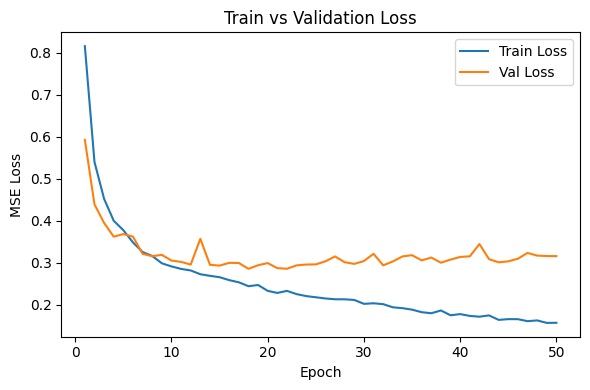

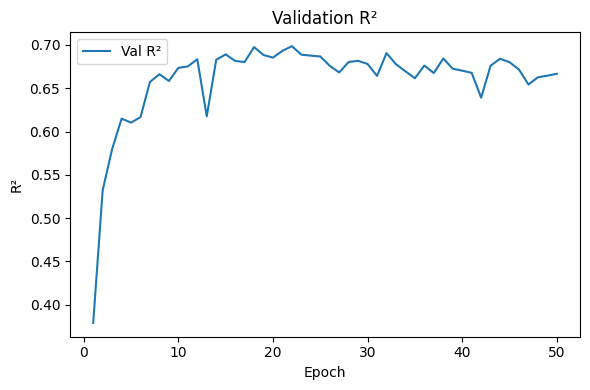

In [59]:
path_train_loss_MetalLinkerTransformer = r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\runs\MetalLinkerSelfAttnModel_0.0001lr_total50epoch\MetalLinkerSelfAttnModel_0.0001lr_total50epoch_train_loss.csv"
path_val_loss_MetalLinkerTransformer = r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\runs\MetalLinkerSelfAttnModel_0.0001lr_total50epoch\MetalLinkerSelfAttnModel_0.0001lr_total50epoch_val_loss.csv"
path_val_r2_MetalLinkerTransformer = r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\runs\MetalLinkerSelfAttnModel_0.0001lr_total50epoch\MetalLinkerSelfAttnModel_0.0001lr_total50epoch_val_r2.csv"

plot_training_curves(path_train_loss_MetalLinkerTransformer, path_val_loss_MetalLinkerTransformer, path_val_r2_MetalLinkerTransformer)

In [67]:
df = pd.read_csv(r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\runs\MetalLinkerSelfAttnModel_0.0001lr_total50epoch\MetalLinkerSelfAttnModel_0.0001lr_total50epoch_val_loss.csv")

print(df.idxmin())

print(df.iloc[16])

5.922444923357530477e-01    16
dtype: int64
5.922444923357530477e-01    0.2852
Name: 16, dtype: float64


In [96]:
# Use early stopped model for testing (epoch at 18 gave the lowest validation loss)

test_model = MetalLinkerSelfAttnModel()

test_model.load_state_dict(torch.load(r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\runs\MetalLinkerSelfAttnModel_0.0001lr_total50epoch\MetalLinkerSelfAttnModel_0.0001lr_epoch18.pt"))

test_result = evaluate_model(test_model, test_loader, target_names = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 
               'pure_uptake_methane_298.00_6500000'], device='cuda')


logKH_CO2:
  RMSE: 0.6676
  R²:   0.5862

pure_uptake_CO2_298.00_15000:
  RMSE: 0.6798
  R²:   0.5454

pure_uptake_methane_298.00_6500000:
  RMSE: 0.1876
  R²:   0.9551


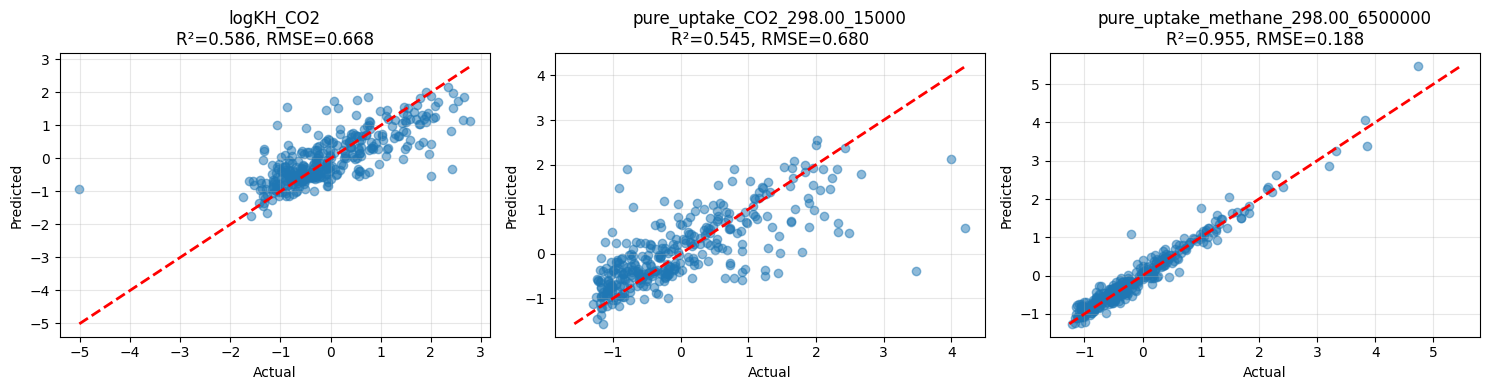

In [97]:
plot_regression_scatter(*test_result, target_names = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 
               'pure_uptake_methane_298.00_6500000'])

In [71]:
class MetalLinkerGeomCrossAttnModel(nn.Module):
    """
    Metal + linker self-attention model -> geometry cross-attention model

    1. Geometry → MLP → geometry embedding (geo_emb)
    2. Metal + OMS + Linker → sequence -> self-attention Transformer Encoder -> CLS out
    3. Bi-directional cross-attention
       - geom_to_seq: geometry attends seq_out
       - seq_to_geom: seq_out이 geometry
    4. Concatenate two resultant vectors  → Predictor MLP → 3 target properties prediction

    """

    def __init__(self,
                 n_geometry=11,
                 metal_vocab_size=55,
                 linker_vocab_size=86,
                 max_metals=5,
                 max_linker_len=198,
                 hidden_dim=128,
                 num_heads=4,
                 num_layers=2,
                 dropout=0.1):
        super().__init__()

        self.n_geometry = n_geometry
        self.metal_vocab_size = metal_vocab_size
        self.linker_vocab_size = linker_vocab_size
        self.max_metals = max_metals
        self.max_linker_len = max_linker_len
        self.hidden_dim = hidden_dim

        # 1. Geometry encoder
        self.geometry_encoder = nn.Sequential(
            nn.Linear(n_geometry, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # 2. Metal + OMS embedding
        self.metal_id_embedding  = nn.Embedding(metal_vocab_size, hidden_dim, padding_idx=0)
        self.metal_oms_embedding = nn.Embedding(2, hidden_dim)   # 0 = closed, 1 = open

        # 3. Linker embedding
        self.linker_embedding = nn.Embedding(linker_vocab_size, hidden_dim, padding_idx=0)

        # Special token & type/segment embedding
        # To embed speical tokens; [CLS] and [SEP]
        self.special_token_embedding = nn.Embedding(2, hidden_dim) # 0 = CLS, 1 = SEP
        # To embed types
        self.token_type_embedding    = nn.Embedding(3, hidden_dim) # token type: 0 = special, 1 = metal, 2 = linker

        # Positional embedding (Trainable)
        # Total Squence Length: [CLS] + metals + [SEP] + linkers
        self.seq_len = 1 + max_metals + 1 + max_linker_len
        self.pos_embedding = nn.Embedding(self.seq_len, hidden_dim)

        # Self-attention Transformer for metal and linker sequence
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True,  # (B, L, H)
        )
        self.sequence_transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # Cross-attentions of geometry and sequence
        # geometry attends sequence
        self.cross_attn_geom_to_seq = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        # sequence attends geometry
        self.cross_attn_seq_to_geom = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )

        # 7. Predictor: input; concatenate two resultant vectors
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 3)  # 3 target properties
        )

        self.attn_score = nn.Linear(hidden_dim, 1) # Later on for attention pooling of all_cls_ctx

    def forward(self, geometry, metal_ids, metal_oms, linker_ids):
        B = geometry.size(0)
        device = geometry.device

        # Geometry embedding
        geo_emb = self.geometry_encoder(geometry)

        # Metal embedding (metal_id + metal_oms)
        metal_id_emb  = self.metal_id_embedding(metal_ids)
        metal_oms_emb = self.metal_oms_embedding(metal_oms.long())
        metal_emb = metal_id_emb + metal_oms_emb

        # PAD metal mask
        metal_valid_mask = (metal_ids != 0).unsqueeze(-1)
        metal_emb = metal_emb * metal_valid_mask

        # Linker embedding
        linker_emb = self.linker_embedding(linker_ids)
        linker_valid_mask = (linker_ids != 0).unsqueeze(-1)
        linker_emb = linker_emb * linker_valid_mask

        # Length of each squence (metal, linker, the whole sequence)
        M = self.max_metals
        L = self.max_linker_len
        seq_len = self.seq_len

        # Making empty sequence embedding slot to be filled up
        seq_emb = torch.zeros(B, seq_len, self.hidden_dim, device=device)

        # Filling up with [CLS] token embedding
        cls_token_ids = torch.zeros(B, dtype=torch.long, device=device) # 0 indicates [CLS]
        cls_emb = self.special_token_embedding(cls_token_ids)
        seq_emb[:, 0, :] = cls_emb

        # Filling up with metal embedding
        seq_emb[:, 1:1+M, :] = metal_emb

        # Filling up with [SEP] token embedding
        sep_token_ids = torch.ones(B, dtype=torch.long, device=device) # 1 indicates [SEP]
        sep_emb = self.special_token_embedding(sep_token_ids)
        sep_idx = 1 + M
        seq_emb[:, sep_idx, :] = sep_emb

        # Filling up with linker embedding
        linker_start = sep_idx + 1
        seq_emb[:, linker_start:linker_start+L, :] = linker_emb

        # Adding token type embedding
        # type: 0 -> special tokens;[CLS] and [SEP], 1 -> metal, 2 -> linker
        type_ids = torch.zeros(B, seq_len, dtype=torch.long, device=device) # set 0 by default, then fill up with metal and linker token type later
        
        # metal position: 1 ~ M
        type_ids[:, 1:1+M] = 1
        # linker position: linker_start ~ linker_start+L-1
        type_ids[:, linker_start:linker_start+L] = 2

        type_emb = self.token_type_embedding(type_ids)
        seq_emb = seq_emb + type_emb

        # Adding positional embedding
        positions = torch.arange(seq_len, device=device)
        pos_emb = self.pos_embedding(positions)[None, :, :]
        seq_emb = seq_emb + pos_emb

        # Bulding padding attention mask; Keeping False for CLS and SEP as they are always important
        pad_mask = torch.zeros(B, seq_len, dtype=torch.bool, device=device)

        # metal padding position
        metal_pad = (metal_ids == 0)
        pad_mask[:, 1:1+M] = metal_pad

        # linker padding position
        linker_pad = (linker_ids == 0)
        pad_mask[:, linker_start:linker_start+L] = linker_pad

        # Transformer self-attention (metal and linker)
        seq_out = self.sequence_transformer(
            seq_emb,
            src_key_padding_mask=pad_mask) #if True for padding, ignore

        # Cross-attention: geometry and sequence, vice versa
        # Making size 1 geometry token; shape would be (batch, 1, hidden)
        geom_token = geo_emb.unsqueeze(1)

        # geom → seq
        geom_ctx, _ = self.cross_attn_geom_to_seq(
            query=geom_token,
            key=seq_out,
            value=seq_out,
            key_padding_mask=pad_mask
        )
        geom_ctx = geom_ctx.squeeze(1)

        # seq → geom
        seq_ctx, _ = self.cross_attn_seq_to_geom(
            query=seq_out,
            key=geom_token,
            value=geom_token) # No masking for this because geometry features are all import; no missing ones



        # Attention Pooling
        scores = self.attn_score(seq_ctx).squeeze(-1)
        scores = scores.masked_fill(pad_mask, -1e9)
        weights = torch.softmax(scores, dim=1)
        weights = weights.unsqueeze(-1)
        seq_ctx = (seq_ctx * weights).sum(dim=1)

        # Fusion & prediction
        combined = torch.cat([geom_ctx, seq_ctx], dim=1)
        output = self.predictor(combined)

        return output


In [72]:
MetalLinkerGeomTransformer = MetalLinkerGeomCrossAttnModel()

print(MetalLinkerGeomTransformer)

MetalLinkerGeomCrossAttnModel(
  (geometry_encoder): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (metal_id_embedding): Embedding(55, 128, padding_idx=0)
  (metal_oms_embedding): Embedding(2, 128)
  (linker_embedding): Embedding(86, 128, padding_idx=0)
  (special_token_embedding): Embedding(2, 128)
  (token_type_embedding): Embedding(3, 128)
  (pos_embedding): Embedding(205, 128)
  (sequence_transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, e

In [73]:
train_history_MetalLinkerGeomTransformer = train_model_regression(
    model= MetalLinkerGeomTransformer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    lr=1e-4,
    device='cuda',
    save_checkpoints=True
)

Epoch 1/50 | Train Loss: 0.7924 | Val Loss: 0.5773 | Val R²: 0.3945
Epoch 2/50 | Train Loss: 0.5083 | Val Loss: 0.3997 | Val R²: 0.5793
Epoch 3/50 | Train Loss: 0.3939 | Val Loss: 0.3651 | Val R²: 0.6116
Epoch 4/50 | Train Loss: 0.3643 | Val Loss: 0.3410 | Val R²: 0.6398
Epoch 5/50 | Train Loss: 0.3321 | Val Loss: 0.3112 | Val R²: 0.6688
Epoch 6/50 | Train Loss: 0.3123 | Val Loss: 0.3076 | Val R²: 0.6738
Epoch 7/50 | Train Loss: 0.2919 | Val Loss: 0.3038 | Val R²: 0.6745
Epoch 8/50 | Train Loss: 0.2895 | Val Loss: 0.2903 | Val R²: 0.6867
Epoch 9/50 | Train Loss: 0.2838 | Val Loss: 0.2770 | Val R²: 0.7012
Epoch 10/50 | Train Loss: 0.2640 | Val Loss: 0.2931 | Val R²: 0.6846
Epoch 11/50 | Train Loss: 0.2635 | Val Loss: 0.2867 | Val R²: 0.6899
Epoch 12/50 | Train Loss: 0.2611 | Val Loss: 0.2795 | Val R²: 0.6993
Epoch 13/50 | Train Loss: 0.2502 | Val Loss: 0.2841 | Val R²: 0.6954
Epoch 14/50 | Train Loss: 0.2427 | Val Loss: 0.2854 | Val R²: 0.6899
Epoch 15/50 | Train Loss: 0.2413 | Val Loss

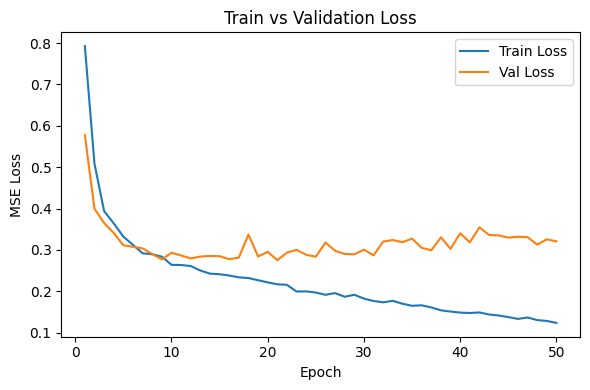

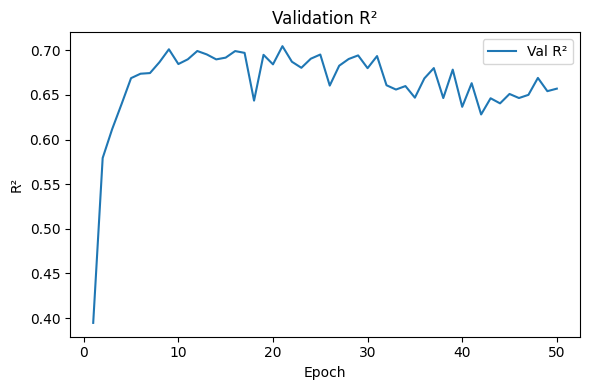

In [74]:
path_train_loss_MetalLinkerGeomTransformer = r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\Code\MetalLinkerGeomCrossAttnModel_0.0001lr_total50epoch_train_loss.csv"
path_val_loss_MetalLinkerGeomTransformer = r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\Code\MetalLinkerGeomCrossAttnModel_0.0001lr_total50epoch_val_loss.csv"
path_val_r2_MetalLinkerGeomTransformer = r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\Code\MetalLinkerGeomCrossAttnModel_0.0001lr_total50epoch_val_r2.csv"

plot_training_curves(path_train_loss_MetalLinkerGeomTransformer, path_val_loss_MetalLinkerGeomTransformer, path_val_r2_MetalLinkerGeomTransformer)


In [77]:
df = pd.read_csv(r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\runs\MetalLinkerGeomCrossAttnModel_0.0001lr_total50epoch\MetalLinkerGeomCrossAttnModel_0.0001lr_total50epoch_val_loss.csv")

print(df.idxmin())

print(df.iloc[19])

5.772773813117634267e-01    19
dtype: int64
5.772773813117634267e-01    0.275116
Name: 19, dtype: float64


In [94]:
# epoch of 21 resulted the lowest validation loss

test_model = MetalLinkerGeomCrossAttnModel()

test_model.load_state_dict(torch.load(r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\runs\MetalLinkerGeomCrossAttnModel_0.0001lr_total50epoch\MetalLinkerGeomCrossAttnModel_0.0001lr_epoch21.pt"))

test_result = evaluate_model(test_model, test_loader, target_names = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 
               'pure_uptake_methane_298.00_6500000'], device='cuda')


logKH_CO2:
  RMSE: 0.6635
  R²:   0.5912

pure_uptake_CO2_298.00_15000:
  RMSE: 0.6741
  R²:   0.5529

pure_uptake_methane_298.00_6500000:
  RMSE: 0.2151
  R²:   0.9410


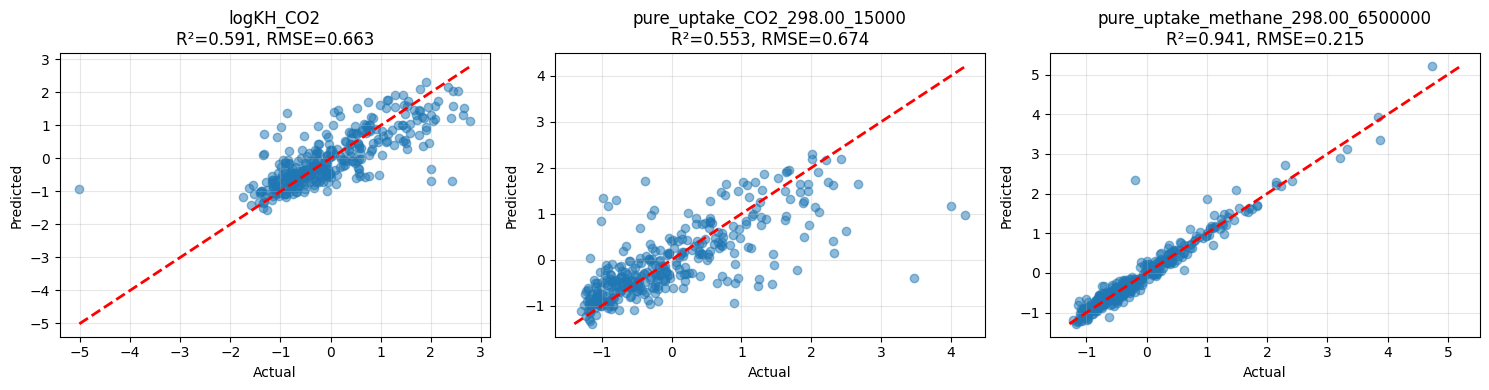

In [95]:
plot_regression_scatter(*test_result, target_names = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 
               'pure_uptake_methane_298.00_6500000'])